# Attribute Importance for Concept Drift - Analysis on the BPI challenge 2017 dataset

The presented attribute importance evaluation framework is applied to the 2017 BPI challgen dataset. This dataset is of the loan application process of a Dutch finance institution.

## Setup
### Imports

In [18]:
# imports
import helper
import pm4py
import pandas as pd
from pm4py.objects.log.importer.xes import importer as xes_importer

from processdrift.framework import drift_detection
from processdrift.framework import drift_explanation
from processdrift.framework import feature_extraction
from processdrift.framework import pop_comparison
from processdrift.framework import windowing

### Data settings and event log loading

In [19]:
# data settings
data_file_path = 'data/real/BPI Challenge 2017.xes'

## Present basic analysis

In [20]:
# load event log
event_log = xes_importer.apply(data_file_path)

parsing log, completed traces :: 100%|██████████| 31509/31509 [01:23<00:00, 377.01it/s]


In [21]:
# get some basic statistics (number of events, number of traces, attributes...)
basic_stats = {}

# event statistics
event_stream = pm4py.convert.convert_to_event_stream(event_log)
number_events = len(event_stream)
basic_stats['Number of events'] = number_events

event_attributes = pm4py.statistics.attributes.log.get.get_all_event_attributes_from_log(event_log)
print(event_attributes)
basic_stats['Event attributes'] = str(event_attributes)

number_event_attributes = len(event_attributes)
basic_stats['Number event attributes'] = number_event_attributes

# trace statistics
number_traces = len(event_log)
basic_stats['Number traces'] = number_traces

trace_attributes = pm4py.statistics.attributes.log.get.get_all_trace_attributes_from_log(event_log)
print(trace_attributes)
basic_stats['Trace attributes'] = str(trace_attributes)

number_trace_attributes = len(trace_attributes)
basic_stats['Number trace attributes'] = number_trace_attributes

basic_stats_series = pd.Series(basic_stats)
basic_stats_series

{'OfferedAmount', 'concept:name', 'MonthlyCost', 'CreditScore', 'Accepted', 'EventID', 'OfferID', 'EventOrigin', 'Action', 'org:resource', 'NumberOfTerms', 'time:timestamp', 'Selected', 'FirstWithdrawalAmount'}
{'ApplicationType', 'RequestedAmount', 'LoanGoal'}


Number of events                                                     1202267
Event attributes           {'OfferedAmount', 'concept:name', 'MonthlyCost...
Number event attributes                                                   14
Number traces                                                          31509
Trace attributes           {'ApplicationType', 'RequestedAmount', 'LoanGo...
Number trace attributes                                                    3
dtype: object

### Configure Primary Drift Detector

In [22]:
# alternative 1: ProDrift Drift detector
primary_process_drift_detector = drift_detection.DriftDetectorProDrift(path_to_prodrift='ProDrift2.5/ProDrift2.5.jar',
                                                                        drift_detection_mechanism='runs',
                                                                        window_size=200,
                                                                        window_mode='adaptive',
                                                                        detect_gradual_as_well=False)

In [23]:
# alternative 2: Configure custom drift detector
# the user can select 
# - a primary feature extractor, specifying which primary axis feature to use
# - a window generator (fixed size or adaptive) incl. the window sizes and further settings
# - a population comparer
# - a threshold for detecting the change points

# primary_feature_extractor = feature_extraction.RelationshipTypesCountFeatureExtractor('Relationship types count')
# primary_window_generator = windowing.FixedSizeWindowGenerator(window_size=150, slide_by=1)
# primary_population_comparer = pop_comparison.HotellingsTSquaredPopComparer()
# primary_threshold = 0.5
# primary_process_drift_detector = drift_detection.DriftDetector(primary_feature_extractor, 
#                                                                primary_window_generator,
#                                                                primary_population_comparer, 
#                                                                threshold=primary_threshold)

In [24]:
# alternative 3: drift detector true known for debugging purposes
# TODO must be deactivated before real analysis is conducted
primary_process_drift_detector = drift_detection.DriftDetectorTrueKnown([655, 2087, 2390, 2674, 2850, 4849, 6522, 11353])

### Configure Secondary Drift Detectors

The user can specify a list of secondary drift detectors.

In [25]:
secondary_window_size = 150
secondary_slide_by = 20

max_distance = 300

secondary_window_generator = windowing.AdaptiveWindowGenerator(secondary_window_size, slide_by=secondary_slide_by)

secondary_population_comparer = pop_comparison.GTestComparer()

secondary_phi = secondary_window_size / secondary_slide_by * 1
secondary_rho = 1
secondary_threshold = 0.05

change_point_extractor = drift_detection.PhiFilterChangePointExtractor(secondary_threshold, secondary_phi, secondary_rho)

secondary_exclude_attributes = ['concept:name']
secondary_drift_detectors = drift_detection.get_all_attribute_drift_detectors(event_log,
                                                                         secondary_window_generator, 
                                                                         secondary_population_comparer,
                                                                         level='trace_and_event',
                                                                         change_point_extractor=change_point_extractor,
                                                                         exclude_attributes=secondary_exclude_attributes)

## Run the Change Point Explainer

In [26]:
# create the change point explainer
drift_explainer = drift_explanation.DriftExplainer(primary_process_drift_detector, secondary_drift_detectors)

# get the change point explanations
primary_and_secondary_changes = drift_explainer.get_primary_and_secondary_changes(event_log, max_distance=max_distance)

In [27]:
primary_changes, secondary_changes = primary_and_secondary_changes
for detector, change_dict in secondary_changes.items():
    print(detector)
    change_points = change_dict['change_points']
    change_series = change_dict['change_series']

    for change_point in change_points:
        try_get_change_series_value = change_series[change_point]

ApplicationType
RequestedAmount
LoanGoal
OfferedAmount
MonthlyCost
CreditScore
Accepted
EventID
OfferID
EventOrigin
Action
org:resource
NumberOfTerms
time:timestamp
Selected
FirstWithdrawalAmount


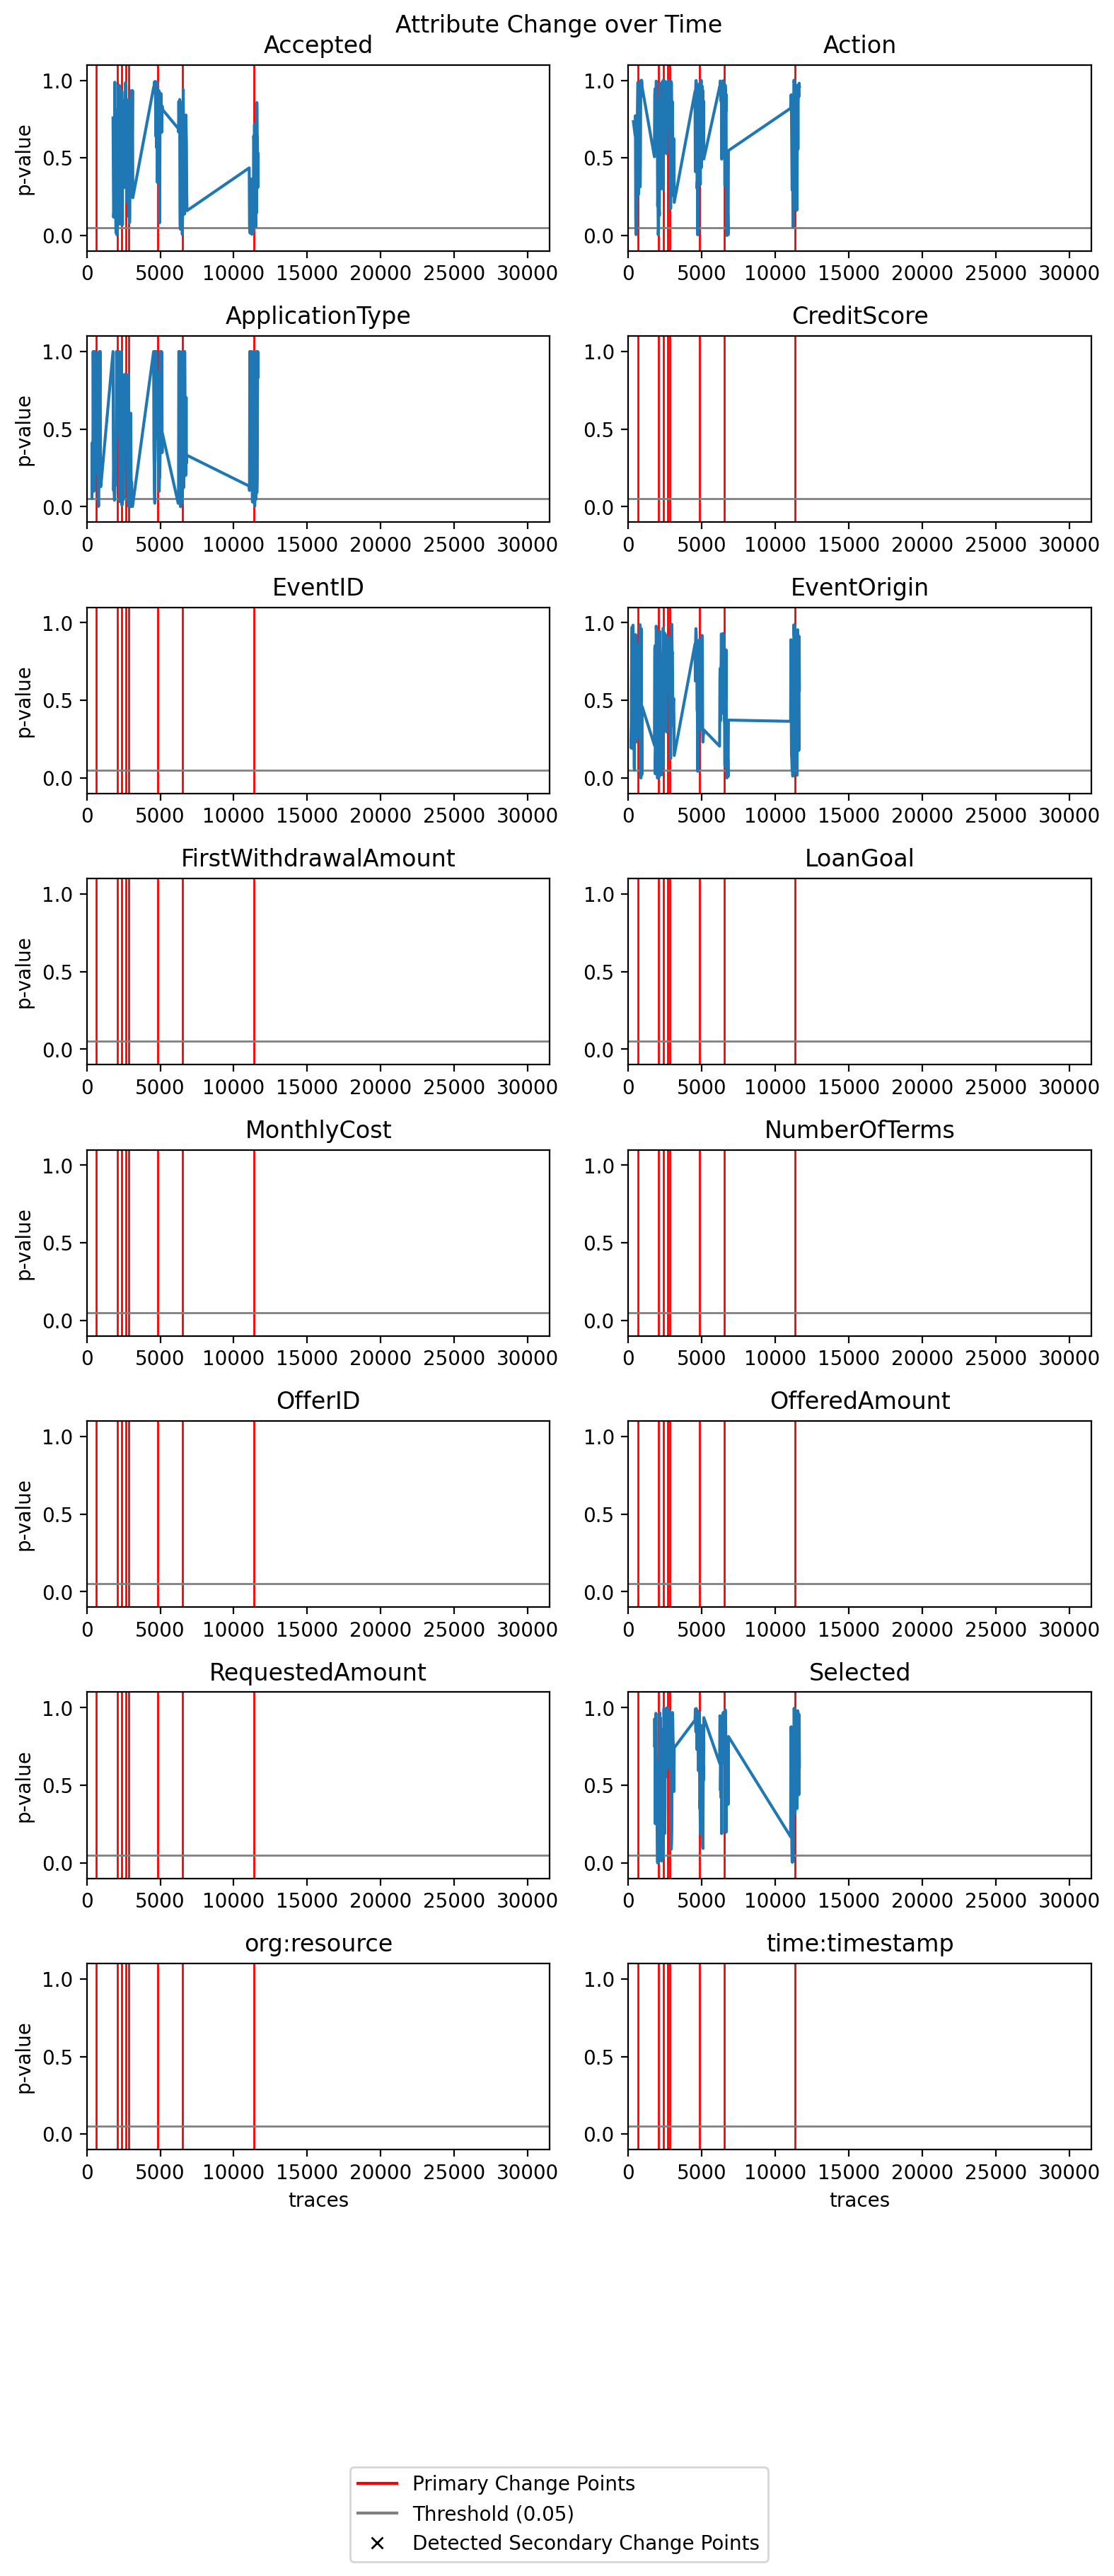

In [28]:
# plot the change point explanations
drift_explanation.plot_primary_and_secondary_changes(primary_and_secondary_changes)
pass

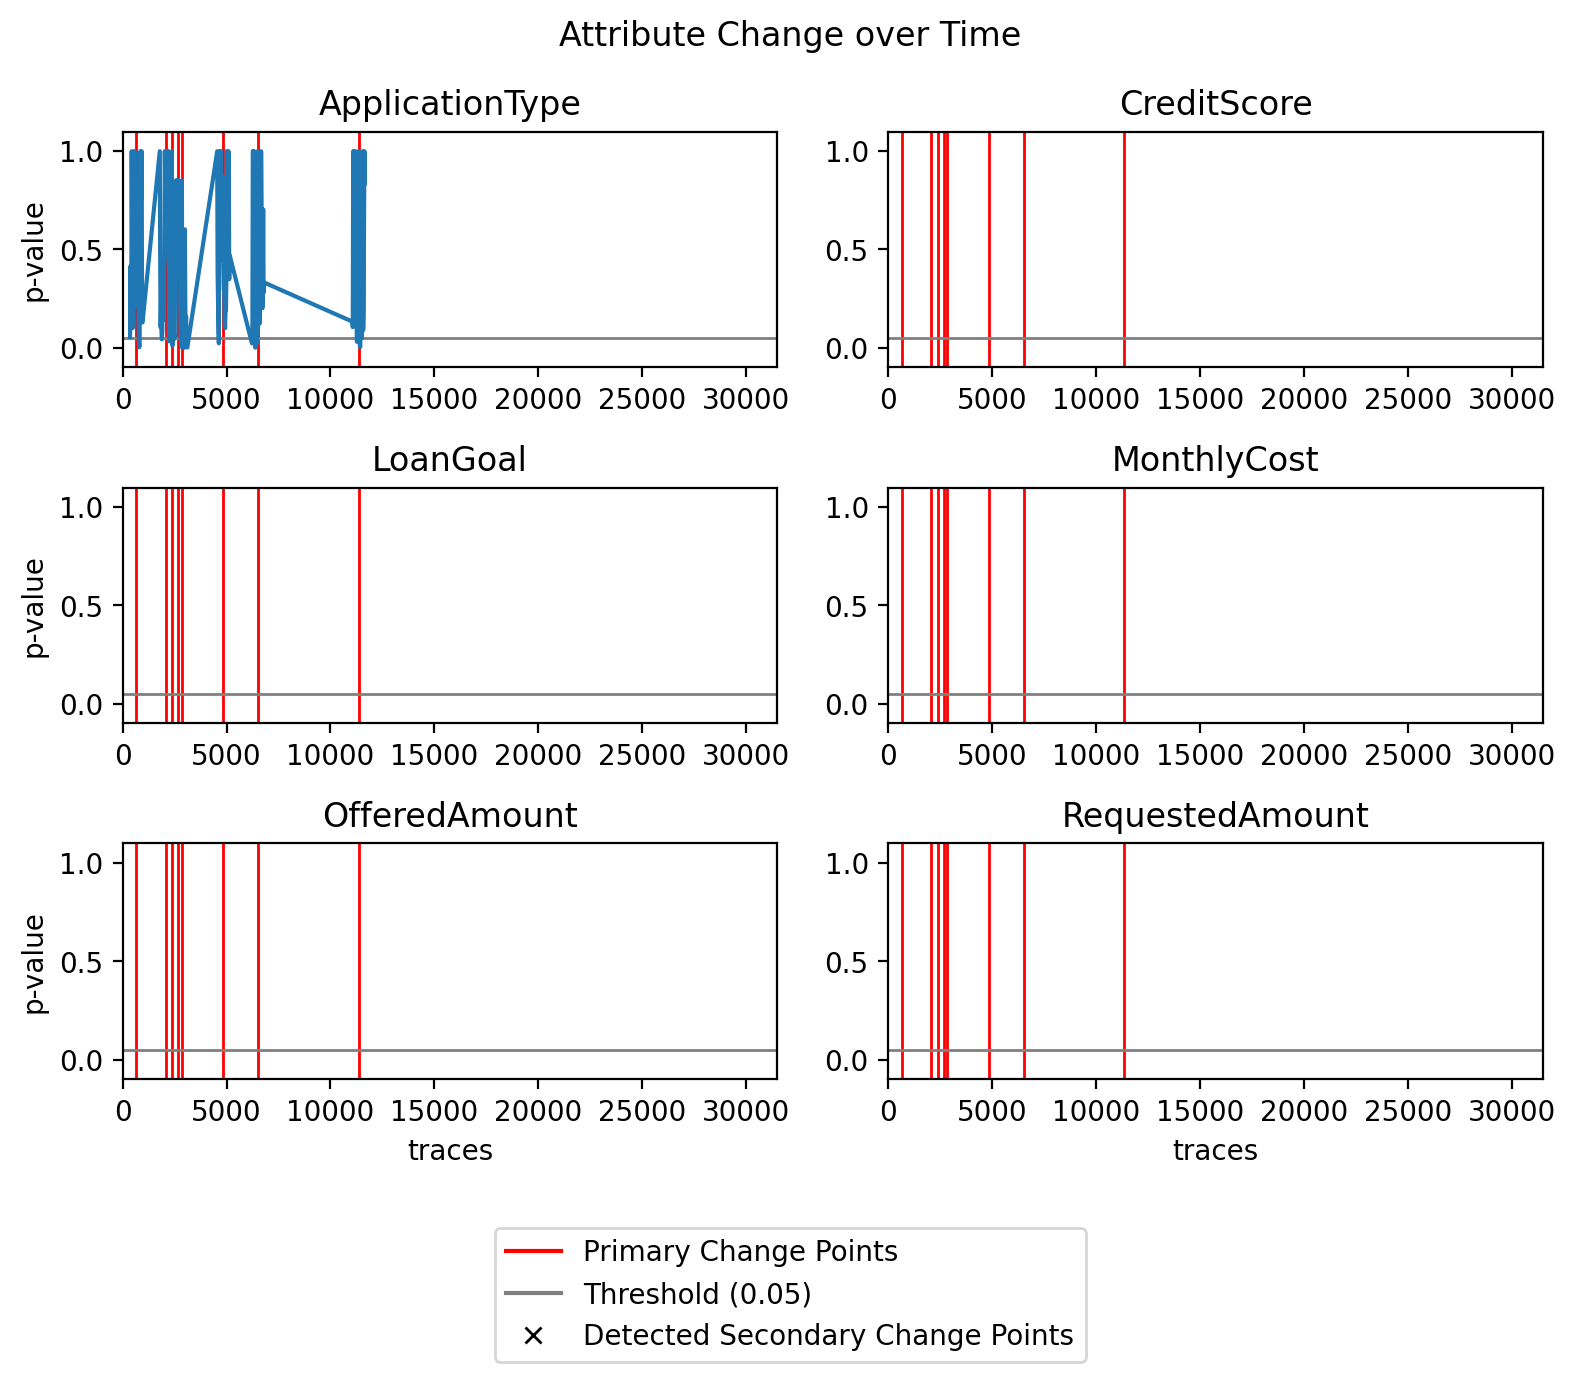

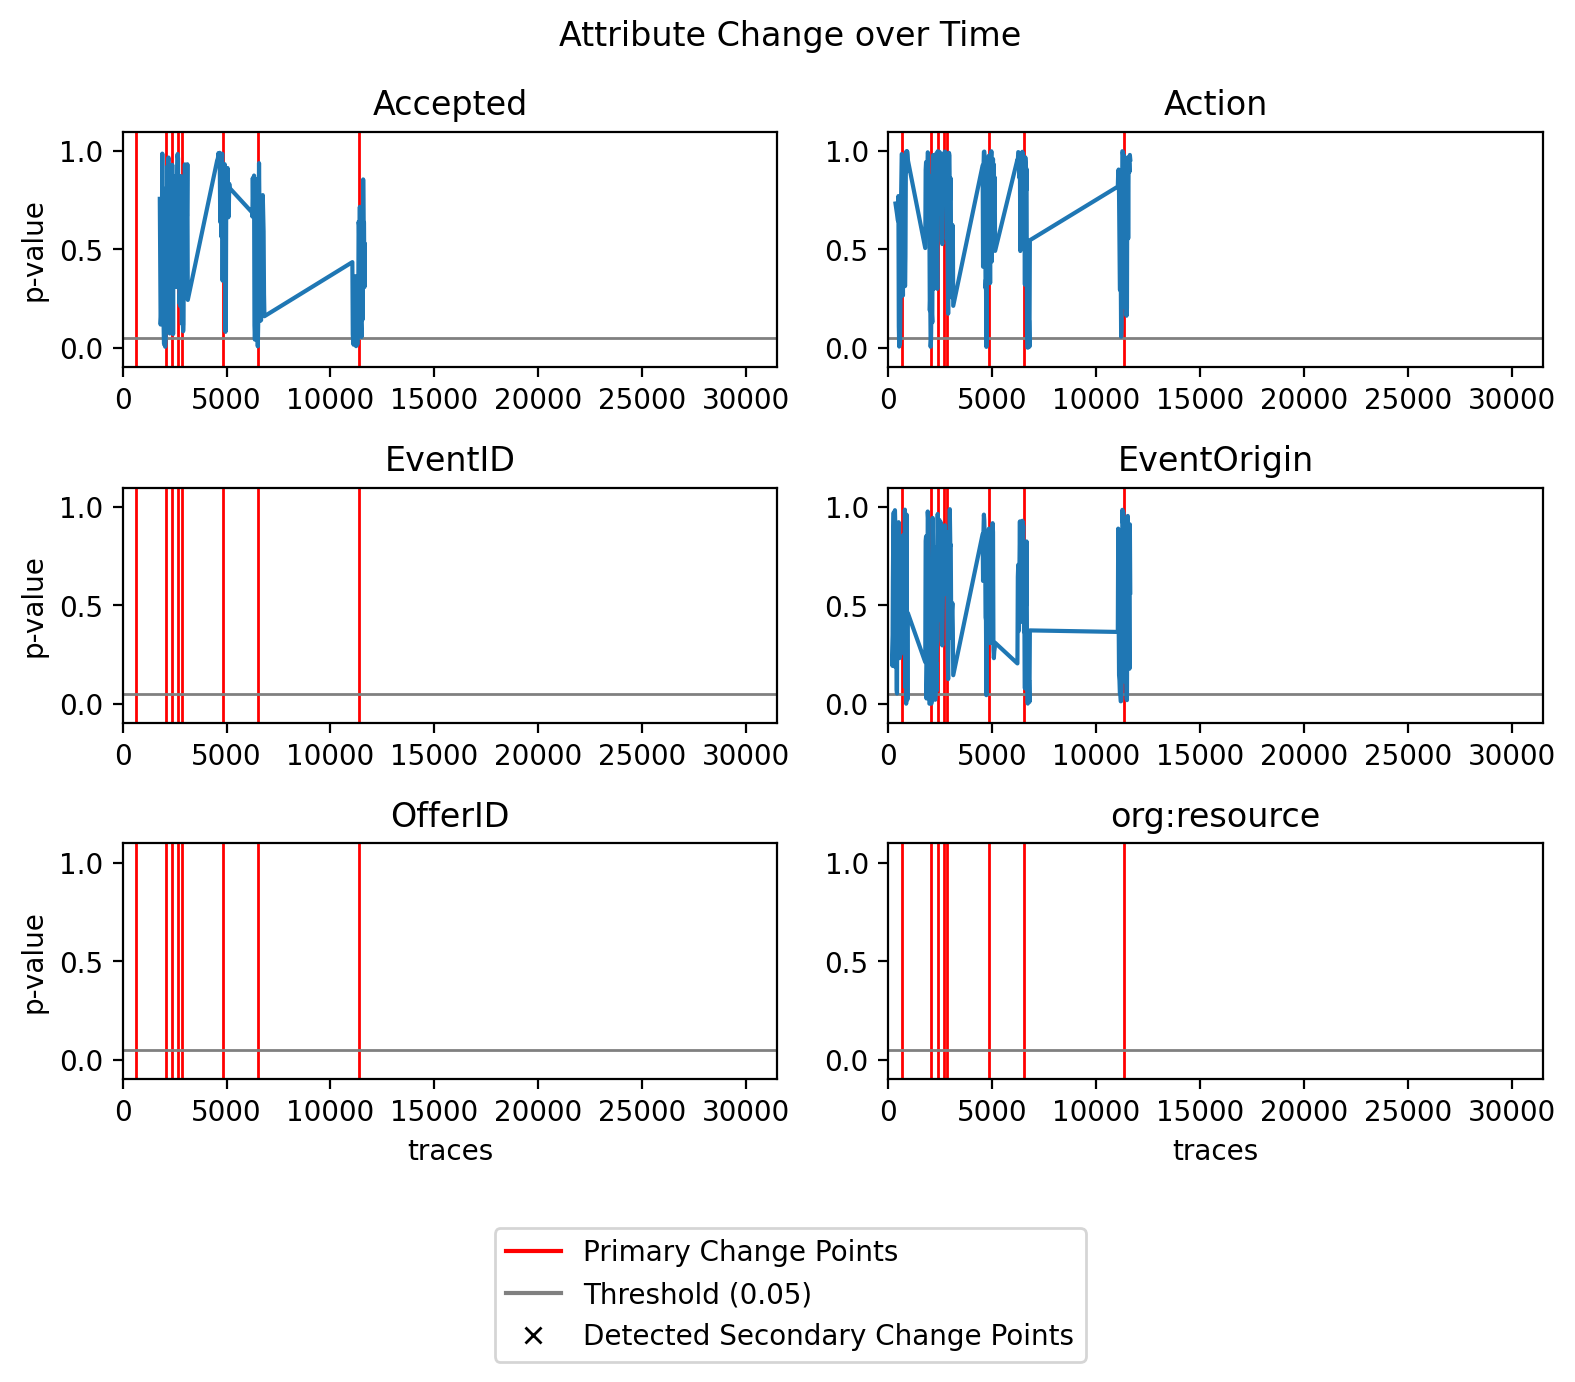

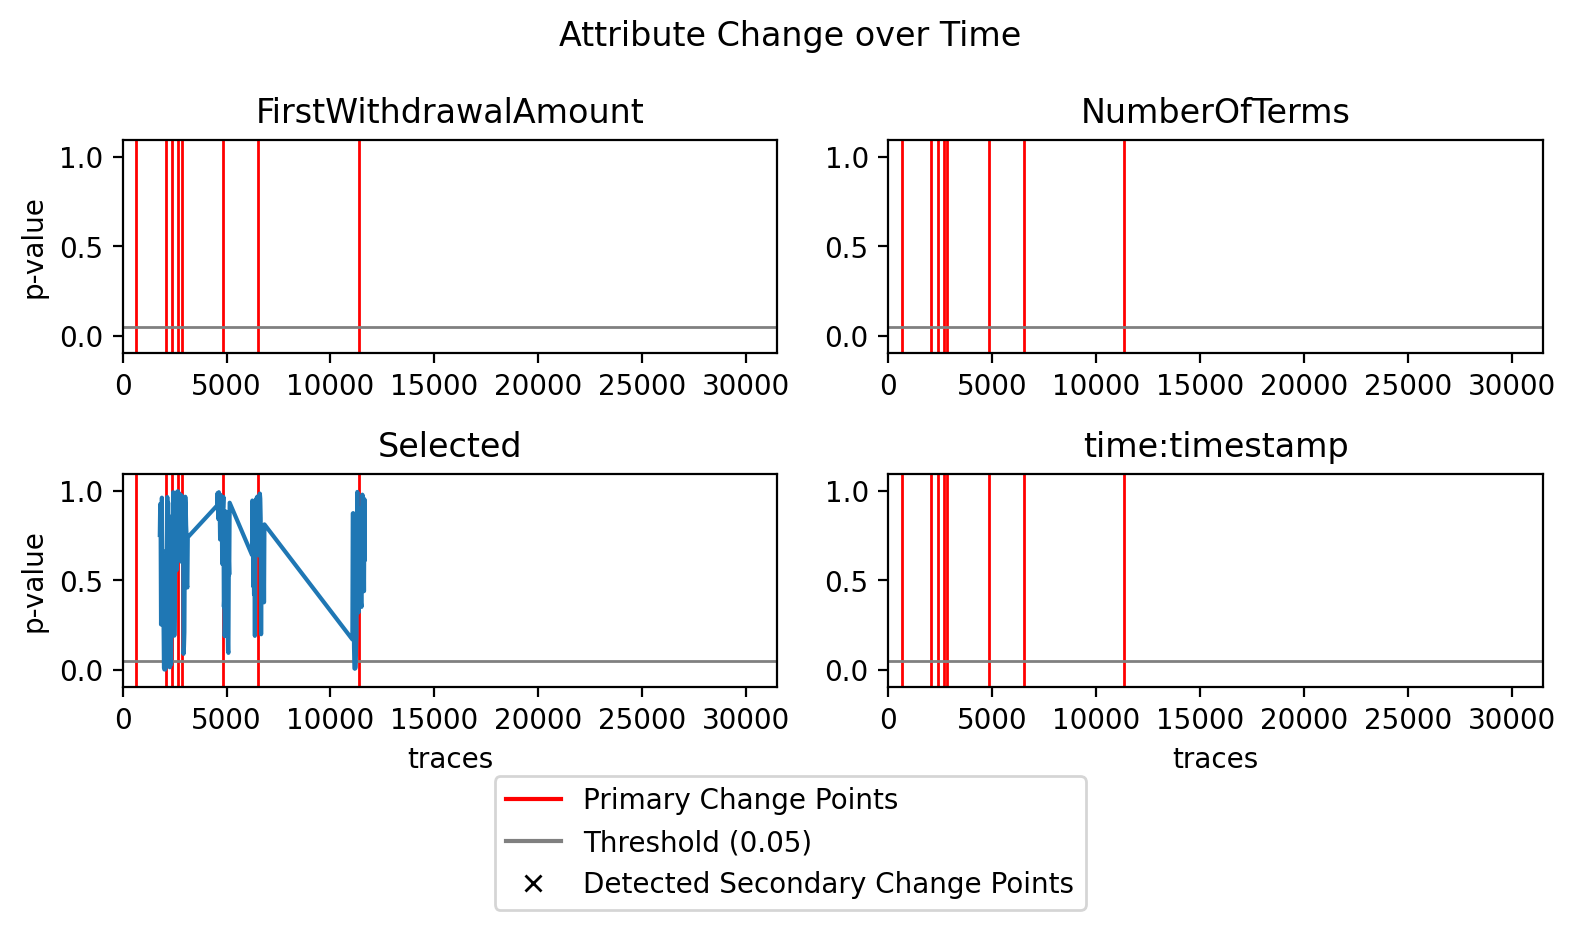

[<module 'matplotlib.pyplot' from 'c:\\Users\\Lennart\\Tools\\Anaconda3\\envs\\concept_drift\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 <module 'matplotlib.pyplot' from 'c:\\Users\\Lennart\\Tools\\Anaconda3\\envs\\concept_drift\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 <module 'matplotlib.pyplot' from 'c:\\Users\\Lennart\\Tools\\Anaconda3\\envs\\concept_drift\\lib\\site-packages\\matplotlib\\pyplot.py'>]

In [29]:
# plot the change point explanations
drift_explanation.multiplot_primary_and_secondary_changes(primary_and_secondary_changes, 6, columns=2)

In [30]:
change_explanations = drift_explanation.get_possible_change_explanations(primary_and_secondary_changes, max_distance=200)
change_explanations

{655: [],
 2087: [],
 2390: [],
 2674: [],
 2850: [],
 4849: [],
 6522: [],
 11353: []}

In [31]:
# put change explanations into a pandas data frame for better analysis
# for that we have to flatten the dictionary
flattended_change_explanations = []
for scp, scp_explanations in change_explanations.items():
    for scp_explanation in scp_explanations:
        dictionary = scp_explanation.copy()
        dictionary['secondary change point'] = scp
        flattended_change_explanations.append(dictionary)

df = pd.DataFrame(flattended_change_explanations)
df.set_index('secondary change point')

KeyError: "None of ['secondary change point'] are in the columns"

14 change explanations where found. 

5 of these are by the feature "org:resource" which is an event-level field. Therefore, we investigate this field further.

In [ ]:
# shown an example for data in "org:resource"
import numpy as np
rng = np.random.default_rng(seed=123)
sample_trace_ids = rng.choice(range(len(event_log)), 10)

for sample_trace_id in sample_trace_ids:
    sample_trace = event_log[sample_trace_id]

    # sample a random event
    sample_event_id = rng.choice(range(len(sample_trace)))
    sample_event = sample_trace[sample_event_id]
    print(sample_event["org:resource"])

User_21
User_121
User_46
User_29
User_1
User_37
User_117
User_5
User_1
User_1


The field appears to hold user information.

Maybe the field always changes significantly?

In [ ]:
from processdrift.framework import drift_detection, feature_extraction

feature_extractor = feature_extraction.AttributeFeatureExtractor('event', 'org:resource')
drift_detector = drift_detection.DriftDetector(feature_extractor, window_generator=secondary_window_generator, population_comparer=secondary_population_comparer)

changes = drift_detector.get_changes(event_log)

<AxesSubplot:>

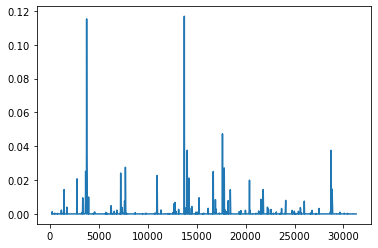

In [ ]:
changes['change_series'].plot()